In [1]:
import os
import random
import numpy as np
from functools import partial
import pickle
from glob import glob
from tqdm.notebook import tqdm
import IPython.display as ipd
import matplotlib.pyplot as plt
import yaml
import torch
from ml_collections import ConfigDict
import scipy
import cv2
from utils import *

import warnings
warnings.filterwarnings("ignore")


device = torch.device('cuda:0')

torch.cuda.is_available()

True

In [2]:
model_name = 'eegadanet'
model_path = 'ckpts/'+model_name

if not os.path.isdir(model_path):
    os.mkdir(model_path)

In [3]:
with open(model_path+'/config.yaml') as f:
    config = ConfigDict(yaml.load(f, Loader=yaml.FullLoader))

config

data:
  chunk_size: 512
  delta_snr:
  - -5
  - 5
  noise_scale: 5
  noise_type: EOG
  sample_rate: 200
model:
  activation: gelu
  att_dim: 128
  att_drop: 0.1
  att_heads: 8
  emb_freqs: 4
  kernel_size: 3
  norm: BatchNorm
  num_blocks:
  - 1
  - 1
  - 1
  - 2
  - 2
  - 4
  num_channels: 16
  scale: 2
training:
  batch_size: 32
  cv_seed: 0
  cv_splits: 3
  early_stop:
    patience: 100
    tolerance: 0.0001
  lr: 0.0002

### Training dataset info

In [4]:
from eeg_positions import get_elec_coords

sr = config.data.sample_rate

_df = get_elec_coords(system='1020', dim='3d')

coord_dict = {}
for i, (c,x,y,z) in enumerate(_df.values):
    if c=='T7':
        coord_dict['T3'] = (x,y,z)
    elif c=='T8':
        coord_dict['T4'] = (x,y,z)
    elif c=='P7':
        coord_dict['T5'] = (x,y,z)
    elif c=='P8':
        coord_dict['T6'] = (x,y,z)
    coord_dict[c] = (x,y,z)

# Evaluation

In [6]:
from torchaudio.transforms import Resample
from scipy.signal import butter, iirnotch, lfilter

# same preprocessing as Klados dataset
def preprocess(x, _sr):
    resample = Resample(_sr, sr)
    x = resample(x)
    b, a = butter(5, [0.5, 40], btype='bandpass', fs=sr, analog=False)
    x = lfilter(b, a, x, axis=-1)
    b, a = iirnotch(50, 30, sr)
    x = lfilter(b, a, x, axis=-1)
    return torch.FloatTensor(x)


def plot_overlayed_psd(a, b, selected_channel, interval=[None,None], size=[10,5]):

    a_psd = PSD(a, selected_channel, interval=interval, fmax=40, n_fft=100)
    b_psd = PSD(b, selected_channel, interval=interval, fmax=40, n_fft=100)

    plt.plot(a_psd, 'orange')
    plt.plot(b_psd, 'black')
    plt.show()


### Load model

In [5]:
from eegadanet import UNet


# k-fold ensemble inference
def denoise(model, y, coords):

    def _denoise(model, y, coords):
        return chunk_and_apply(
            partial(model, coords=coords, save_matrix=True),
            y.to(device), 
            batch_size=config.training.batch_size, 
            chunk_size=config.data.chunk_size
        )

    preds = [_denoise(_model, y, coords) for _model in model]
    
    return torch.stack(preds).mean(0)
    
        
epoch = 307
ckpts = torch.load(model_path+f'/epoch{epoch}.ckpt', map_location=device)

model = []
for ckpt in ckpts:
    _model = UNet(config.model).eval().to(device)
    _model.load_state_dict(ckpt)
    model.append(_model)

### BioSource
- sr=250, powerline_freq=50
- bandpass=None, notch=False

In [7]:
electrodes_biosource = ['Fp2','F8','T4','T6','O2','F4','C4','P4','Fz','Cz','Pz','Fp1','F7','T3','T5','O1','F3','C3','P3']
coords = torch.FloatTensor([coord_dict[e] for e in electrodes_biosource])

data_path = 'data/biosource/sig_ictal.mat'
_y = torch.FloatTensor(scipy.io.loadmat(data_path)['sig_ictal'])[:-2]

_y.shape

torch.Size([19, 2500])

In [8]:
y = preprocess(_y, _sr=250)
x = denoise(model, y, coords)

y.shape, x.shape

(torch.Size([19, 2000]), torch.Size([19, 2000]))

Using matplotlib as 2D backend.


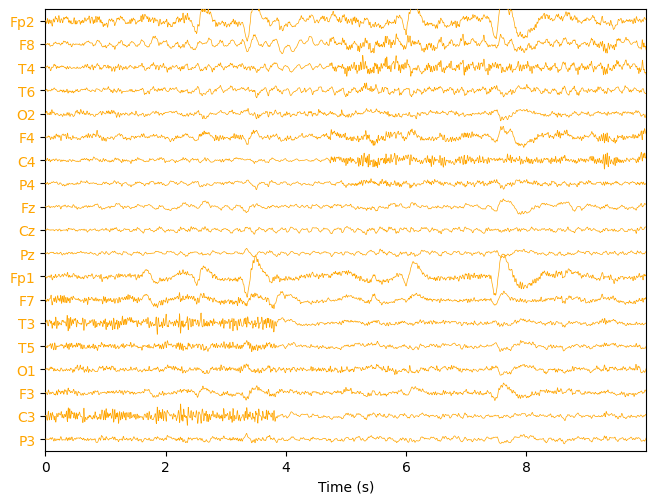

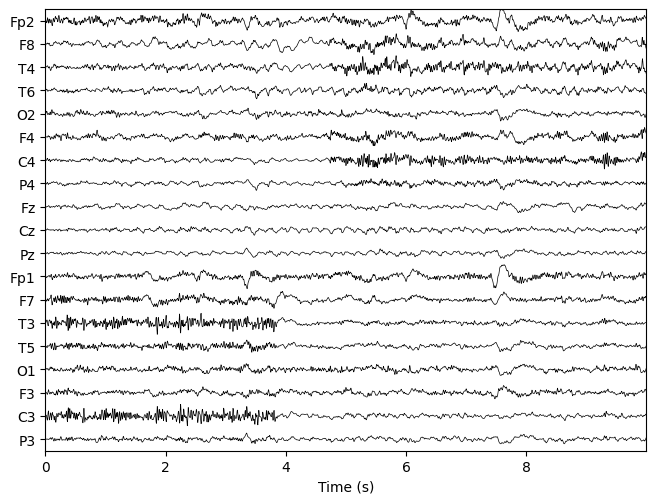

In [9]:
raw_y = tensor2raw(y, sr, electrodes_biosource, scale=0.25)
raw_x = tensor2raw(x, sr, electrodes_biosource, scale=0.25)

plot_overlayed_chart(raw_y, raw_x, model_path+'/chart_biosource.png', size=[7,5])

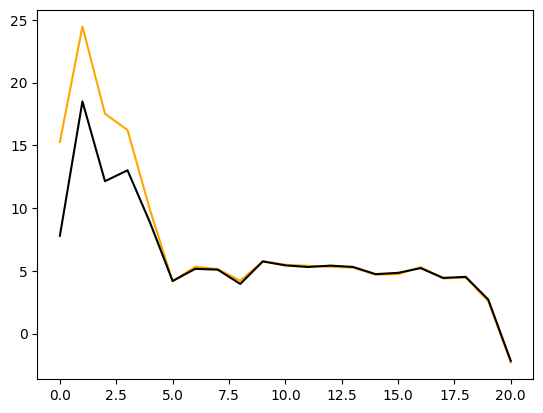

In [10]:
raw_y = tensor2raw(y, sr, electrodes_biosource)
raw_x = tensor2raw(x, sr, electrodes_biosource)

plot_overlayed_psd(raw_y, raw_x, 'Fp2', size=[6,5])

### ISRUC
- sr=200, powerline_freq=50
- bandpass=[0.5, 35], notch=True

In [11]:
electrodes_isruc = ['F3','C3','O1','F4','C4','O2'] 
coords = torch.FloatTensor([coord_dict[e] for e in electrodes_isruc])

data_path = 'data/isruc_group3/'
eeg_paths = glob(data_path+'*.npy')
eegs = torch.FloatTensor(np.concatenate([np.load(path)[:,:8] for path in tqdm(eeg_paths)]))
eegs.shape

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([8589, 8, 6000])

In [12]:
start_t, end_t = 14, 24
y_eog = eegs[8223,:,start_t*sr:end_t*sr]
y, eog = y_eog[:6], y_eog[[7,6]]

x = denoise(model, y, coords) 

y.shape, x.shape

(torch.Size([6, 2000]), torch.Size([6, 2000]))

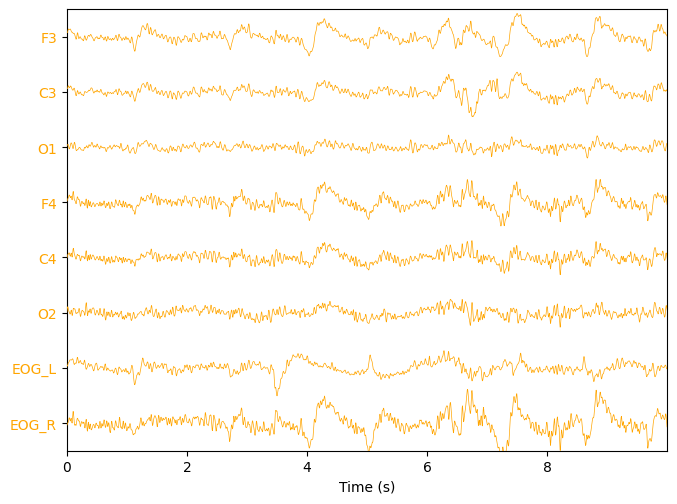

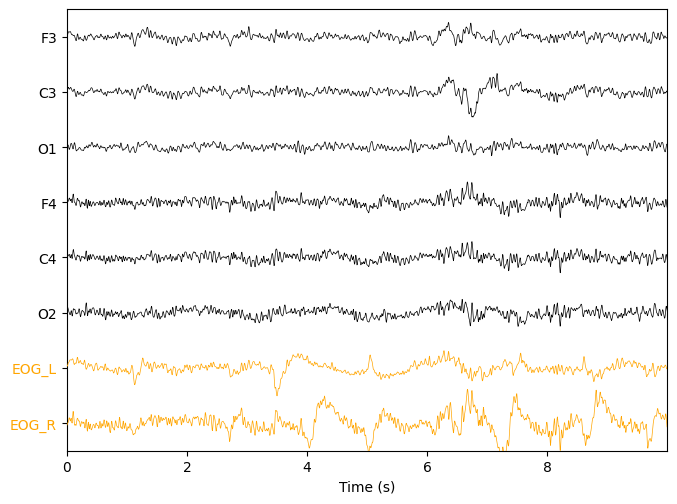

In [13]:
electrodes_isruc_eog = electrodes_isruc+['EOG_L','EOG_R']
ch_types=[('eog' if ('EOG' in e) else 'eeg') for e in electrodes_isruc_eog]

raw_y = tensor2raw(torch.cat([y, eog*10]), sr, electrodes_isruc_eog, scale=3, ch_types=ch_types)
raw_x = tensor2raw(torch.cat([x, eog*10]), sr, electrodes_isruc_eog, scale=3, ch_types=ch_types)

plot_overlayed_chart(raw_y, raw_x, model_path+'/chart_isruc.png', size=[7,5])

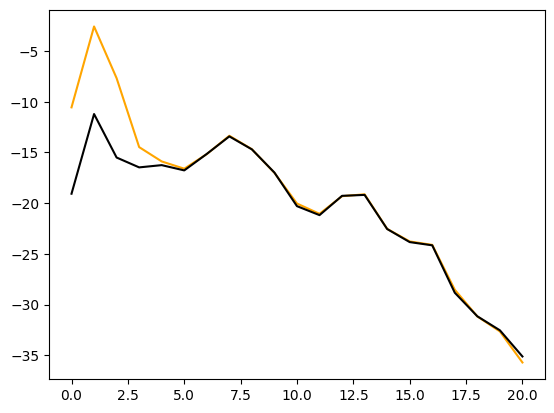

In [14]:
raw_y = tensor2raw(y, sr, electrodes_isruc)
raw_x = tensor2raw(x, sr, electrodes_isruc)

plot_overlayed_psd(raw_y, raw_x, 'F4', size=[6,5])

# Visualize attention matrix

In [15]:
# channels used for last inference
electrodes = electrodes_isruc

# collect all attention matrices
M = []
for _model in model:
    _M = torch.stack([
        att.matrix for att in 
        [block.att for block in _model.down_blocks] + [_model.bottleneck_block.att] + [block.att for block in _model.up_blocks]
    ], 1)
    M.append(_M)

M = torch.stack(M).mean(dim=(0,1))  # mean over models and segments

M.shape  # [layers, heads, C, C]

torch.Size([11, 8, 6, 6])

In [16]:
from eeg_positions import get_elec_coords

_df = get_elec_coords(system='1020')

coord_dict_2d = {}
for i, (c,x,y) in enumerate(_df.values):
    if c=='T7':
        coord_dict_2d['T3'] = (x,y)
    elif c=='T8':
        coord_dict_2d['T4'] = (x,y)
    elif c=='P7':
        coord_dict_2d['T5'] = (x,y)
    elif c=='P8':
        coord_dict_2d['T6'] = (x,y)
    coord_dict_2d[c] = (x,y)

### per head

F3 (Layer 2)


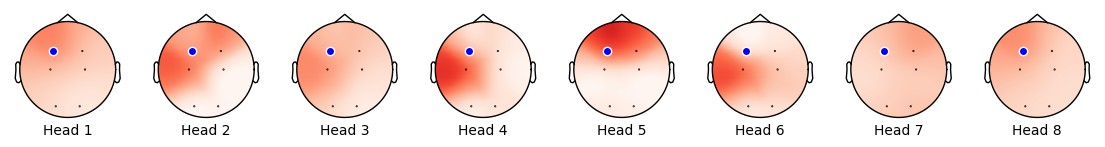

In [17]:
import mne

# specify query channel and model layer
E = 'F3'
L = 2


W = M[L][:,electrodes.index(E)]

print(E, f'(Layer {L})')

fig, axes = plt.subplots(1, len(W), figsize=(14, 3))
for i, ax in enumerate(axes):
    ax.set_xlabel(f'Head {i+1}')
    mne.viz.plot_topomap(
        W[i].cpu(), 
        np.array([coord_dict_2d[e] for e in electrodes]), 
        mask=np.array([e==E for e in electrodes]), 
        mask_params=dict(markerfacecolor='b', markeredgecolor='w', linewidth=0, markersize=6), 
        contours=0, 
        sphere=(0,0,0,0.9), 
        res=16, size=1, 
        cmap='Reds', vlim=(0.0,0.8),
        show=False, axes=ax
    )

plt.show()

### per layer (average over heads)

F3


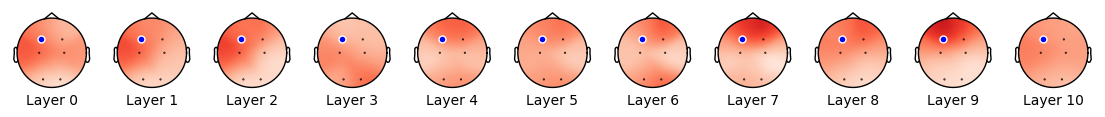

In [18]:
import mne

# specify query channel
E = 'F3'

print(E)
fig, axes = plt.subplots(1, len(M), figsize=(14, 3))
for i, ax in enumerate(axes):
    w = M[i][:,electrodes.index(E)].mean(0)
    ax.set_xlabel(f'Layer {i}')
    mne.viz.plot_topomap(
        w.cpu(), 
        np.array([coord_dict_2d[e] for e in electrodes]), 
        mask=np.array([e==E for e in electrodes]), 
        mask_params=dict(markerfacecolor='b', markeredgecolor='w', linewidth=0, markersize=5), 
        contours=0, 
        sphere=(0,0,0,0.9), 
        res=16, size=1, 
        cmap='Reds', vlim=(0.0,0.5),
        show=False, axes=ax
    )
    
plt.show()

### per channel (average over layers & heads)

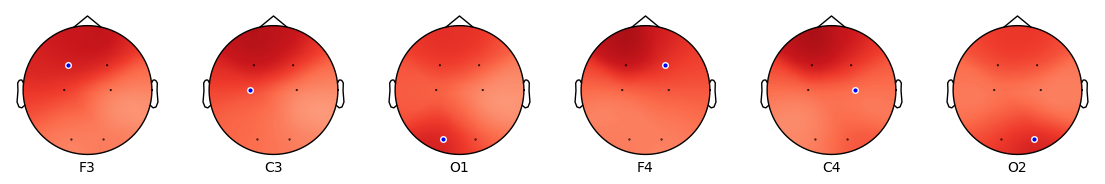

In [19]:
import mne

fig, axes = plt.subplots(1, len(electrodes), figsize=(14, 3))
for i, ax in enumerate(axes):
    E = electrodes[i]
    w = M[...,i,:].mean(dim=(0,1))
    ax.set_xlabel(E)
    mne.viz.plot_topomap(
        w.cpu(), 
        np.array([coord_dict_2d[e] for e in electrodes]), 
        mask=np.array([e==E for e in electrodes]), 
        mask_params=dict(markerfacecolor='b', markeredgecolor='w'), 
        contours=0, 
        sphere=(0,0,0,0.9), 
        res=16, size=1, 
        cmap='Reds', vlim=(0.0,0.3),
        show=False, axes=ax
    )
        
plt.show()